In [21]:
import urllib
import re
import os
import numpy as np
from scipy.misc import imsave
from PIL import Image
import sys
import cntk as C

In [2]:
model = C.load_model('./vihance/VDSR_Scraped.model')

In [3]:
model

Composite(Convolution): Input('real_X', [#], [3 x 64 x 64]) -> Output('Block2377_Output_0', [#], [3 x 64 x 64])

In [25]:
def evaluate(filename, model, outfile, output_dims, pre_upscale = False, clear_up = False, residual_model = False):
    img = Image.open(filename)

    #upscaling coefficient
    coef = 2

    #at each step, we will evaluate subpatch (x : x + range_x, y : y + range_y) of original image
    #patch by patch, we will resolve the whole image
    range_x = output_dims // coef
    range_y = output_dims // coef

    #how many bounding pixels from resulting patch should be excluded?
    #this is important because boundaries tend to be predicted less accurately
    offset = output_dims // 10

    #after we evaluate a subpatch, how much we move down/right to get the next one
    #we subtract offset to cover those pixels which were boundary in the previous subpatch
    step_x = range_x - offset
    step_y = range_y - offset

    #situation which should not occur, if we need preprocess, we will need to clear up the result
    if((pre_upscale) and (not clear_up)):
        print("Pre-magnified image is not being cleared up.")
        return

    #pre-magnify picture if needed
    if(pre_upscale):
        img = img.resize((coef * img.width, coef * img.height), Image.BICUBIC)

    #if the current image is being cleared up with no further uspcaling,
    #set coef to 1 and other parameters accordingly
    if(clear_up):
        result = np.zeros((img.height, img.width, 3))
        range_x = output_dims
        range_y = output_dims
        step_x = range_x - 2 * offset
        step_y = range_y - 2 * offset
        coef = 1
    #otherwise, set result to be coef (2 by default) times larger than image
    else:
        result = np.zeros((coef * img.height, coef * img.width, 3))

    rect = np.array(img, dtype = np.float32)

    #if the image is too small for some models to work on it, pad it with zeros
    if(rect.shape[0] < range_y):
        pad = np.zeros((range_y - rect.shape[0], rect.shape[1], rect.shape[2]))
        rect = np.concatenate((rect, pad), axis = 0).astype(dtype = np.float32)

    if(rect.shape[1] < range_x):
        pad = np.zeros((rect.shape[0], range_x - rect.shape[1], rect.shape[2]))
        rect = np.concatenate((rect, pad), axis = 1).astype(dtype = np.float32)

    x = 0
    y = 0

    #take subpatch by subpatch and resolve them to get the final image result
    while(y < img.width):
        x = 0
        while(x < img.height):
            rgb_patch = rect[x : x + range_x, y : y + range_y]
            rgb_patch = rgb_patch[..., [2, 1, 0]]
            rgb_patch = np.ascontiguousarray(np.rollaxis(rgb_patch, 2))
            pred = np.squeeze(model.eval({model.arguments[0] : [rgb_patch]}))

            img1 = np.ascontiguousarray(rgb_patch.transpose(2, 1, 0))
            img2 = np.ascontiguousarray(pred.transpose(2, 1, 0))

            #if model predicts residual image,
            #scale back the prediction and add to starting patch
            #otherwise just scale back
            if(residual_model):
                img2 = 255.0 * img2 + img1
            else:
                img2 = pred.transpose(2, 1, 0)
                img2 = img2 * 255.0

            # make sure img2 is C Contiguous as we just transposed it
            img2 = np.ascontiguousarray(img2)
            #make sure no pixels are outside [0, 255] interval
            for _ in range(2):
                img2 = C.relu(img2).eval()
                img2 = np.ones(img2.shape) * 255.0 - img2

            rgb = img2[..., ::-1]
            patch = rgb.transpose(1, 0, 2)

            #fill in the pixels in the middle of the subpatch
            #don't fill those within offset range to the boundary
            for h in range(coef * x + offset, coef * x + output_dims - offset):
                for w in range(coef * y + offset, coef * y + output_dims - offset):
                    for col in range(0, 3):
                        result[h][w][col] = patch[h - coef * x][w - coef * y][col]

            #pad top
            if(x == 0):
                for h in range(offset):
                    for w in range(coef * y, coef * y + output_dims):
                        for col in range(0, 3):
                            result[h][w][col] = patch[h][w - coef * y][col]

            #pad left
            if(y == 0):
                for h in range(coef * x, coef * x + output_dims):
                    for w in range(offset):
                        for col in range(0, 3):
                            result[h][w][col] = patch[h - coef * x][w][col]

            #pad bottom
            if(x == img.height - range_x):
                for h in range(coef * img.height - offset, coef * img.height):
                    for w in range(coef * y, coef * y + output_dims):
                        for col in range(0, 3):
                            result[h][w][col] = patch[h - coef * x][w - coef * y][col]

            #pad right
            if(y == img.width - range_y):
                for h in range(coef * x, coef * x + output_dims):
                    for w in range(coef * img.width - offset, coef * img.width):
                        for col in range(0, 3):
                            result[h][w][col] = patch[h - coef * x][w - coef * y][col]

            #reached bottom of image
            if(x == img.height - range_x):
                break
            #next step by x, we must not go out of bounds
            x = min(x + step_x, img.height - range_x)

        #reached right edge of image
        if(y == img.width - range_x):
            break
        #next step by y, we must not go out of bounds
        y = min(y + step_y, img.width - range_x)

    result = np.ascontiguousarray(result)

    #save result
    print("yay")
    imsave(outfile, result.astype(np.uint8))

In [12]:
from IPython.display import Image
Image(url='./360p/9_frame90.0_360p.jpg')

In [13]:
Image(url='./720p/9_frame90.0_720p.jpg')

In [31]:
from PIL import Image
import time
t = time.time()
evaluate('./360p/9_frame90.0_360p.jpg', model, 'test.jpg', output_dims=64, pre_upscale=True, clear_up=True)
elapsed = time.time() - t
print(elapsed)

yay
133.21489572525024


/home/dsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:139: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [32]:
from IPython.display import Image as showimage
showimage(url='test.jpg')

## WTF IS THIS

In [42]:
t = time.time()
evaluate('./360p/9_frame90.0_360p.jpg', model, 'test2.jpg', output_dims=64, pre_upscale = True, clear_up = True, residual_model = True)
elapsed = time.time() - t
print(elapsed)

yay
132.65659737586975


/home/dsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:139: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [43]:
showimage(url='test2.jpg')

In [61]:
t = time.time()
evaluate('test2.jpg', model, 'test3.jpg', output_dims=64, pre_upscale = True, clear_up = True, residual_model = True)
elapsed = time.time() - t
print(elapsed)

yay


/home/dsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:139: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


526.5797374248505


In [62]:
showimage(url='test3.jpg')

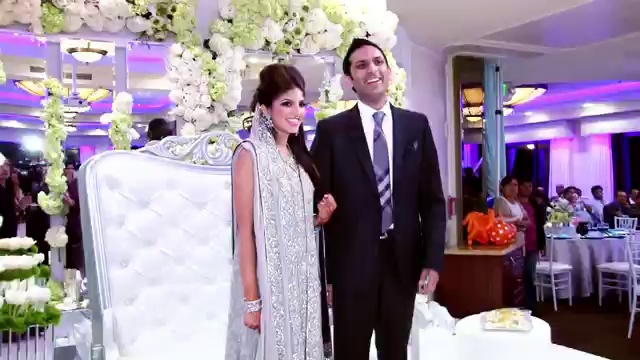

In [69]:
showimage('./360p/11_frame90.0_360p.jpg')

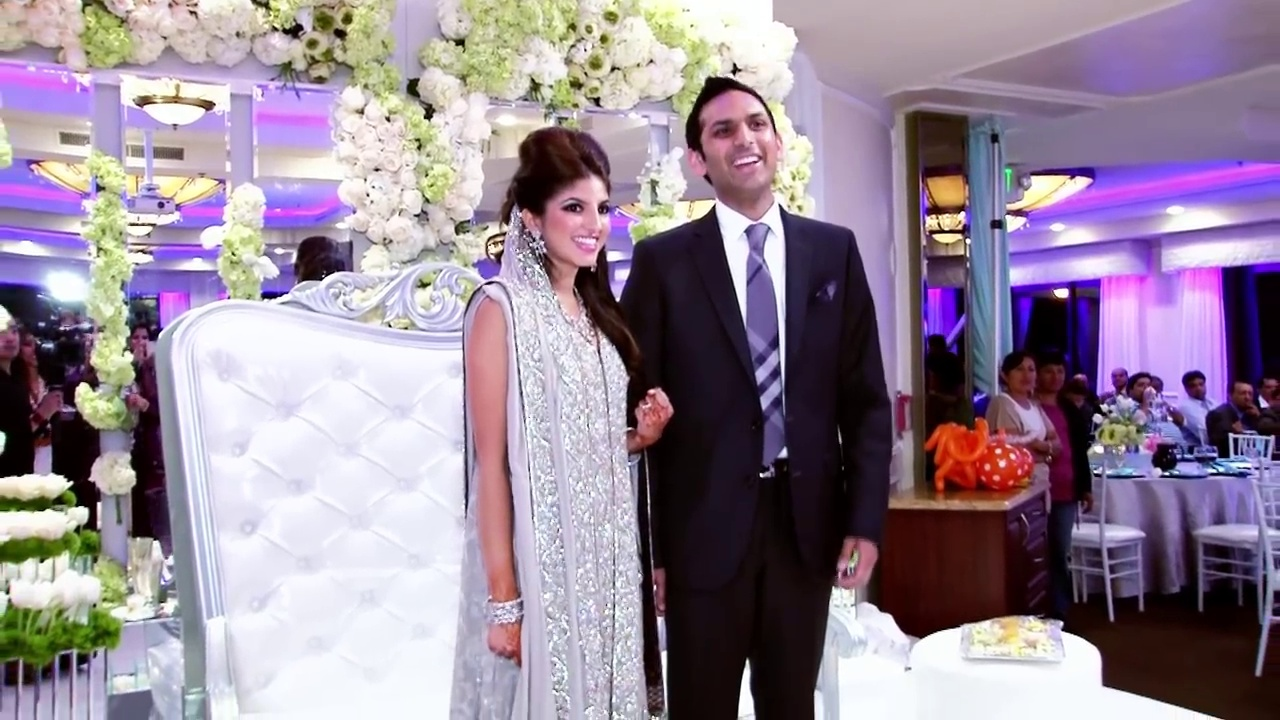

In [68]:
showimage('./720p/11_frame90.0_720p.jpg')

In [70]:
t = time.time()
evaluate('./720p/11_frame90.0_720p.jpg', model, 'test4.jpg', output_dims=64, pre_upscale = True, clear_up = True, residual_model = True)
elapsed = time.time() - t
print(elapsed)

yay


/home/dsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:139: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


524.1422441005707


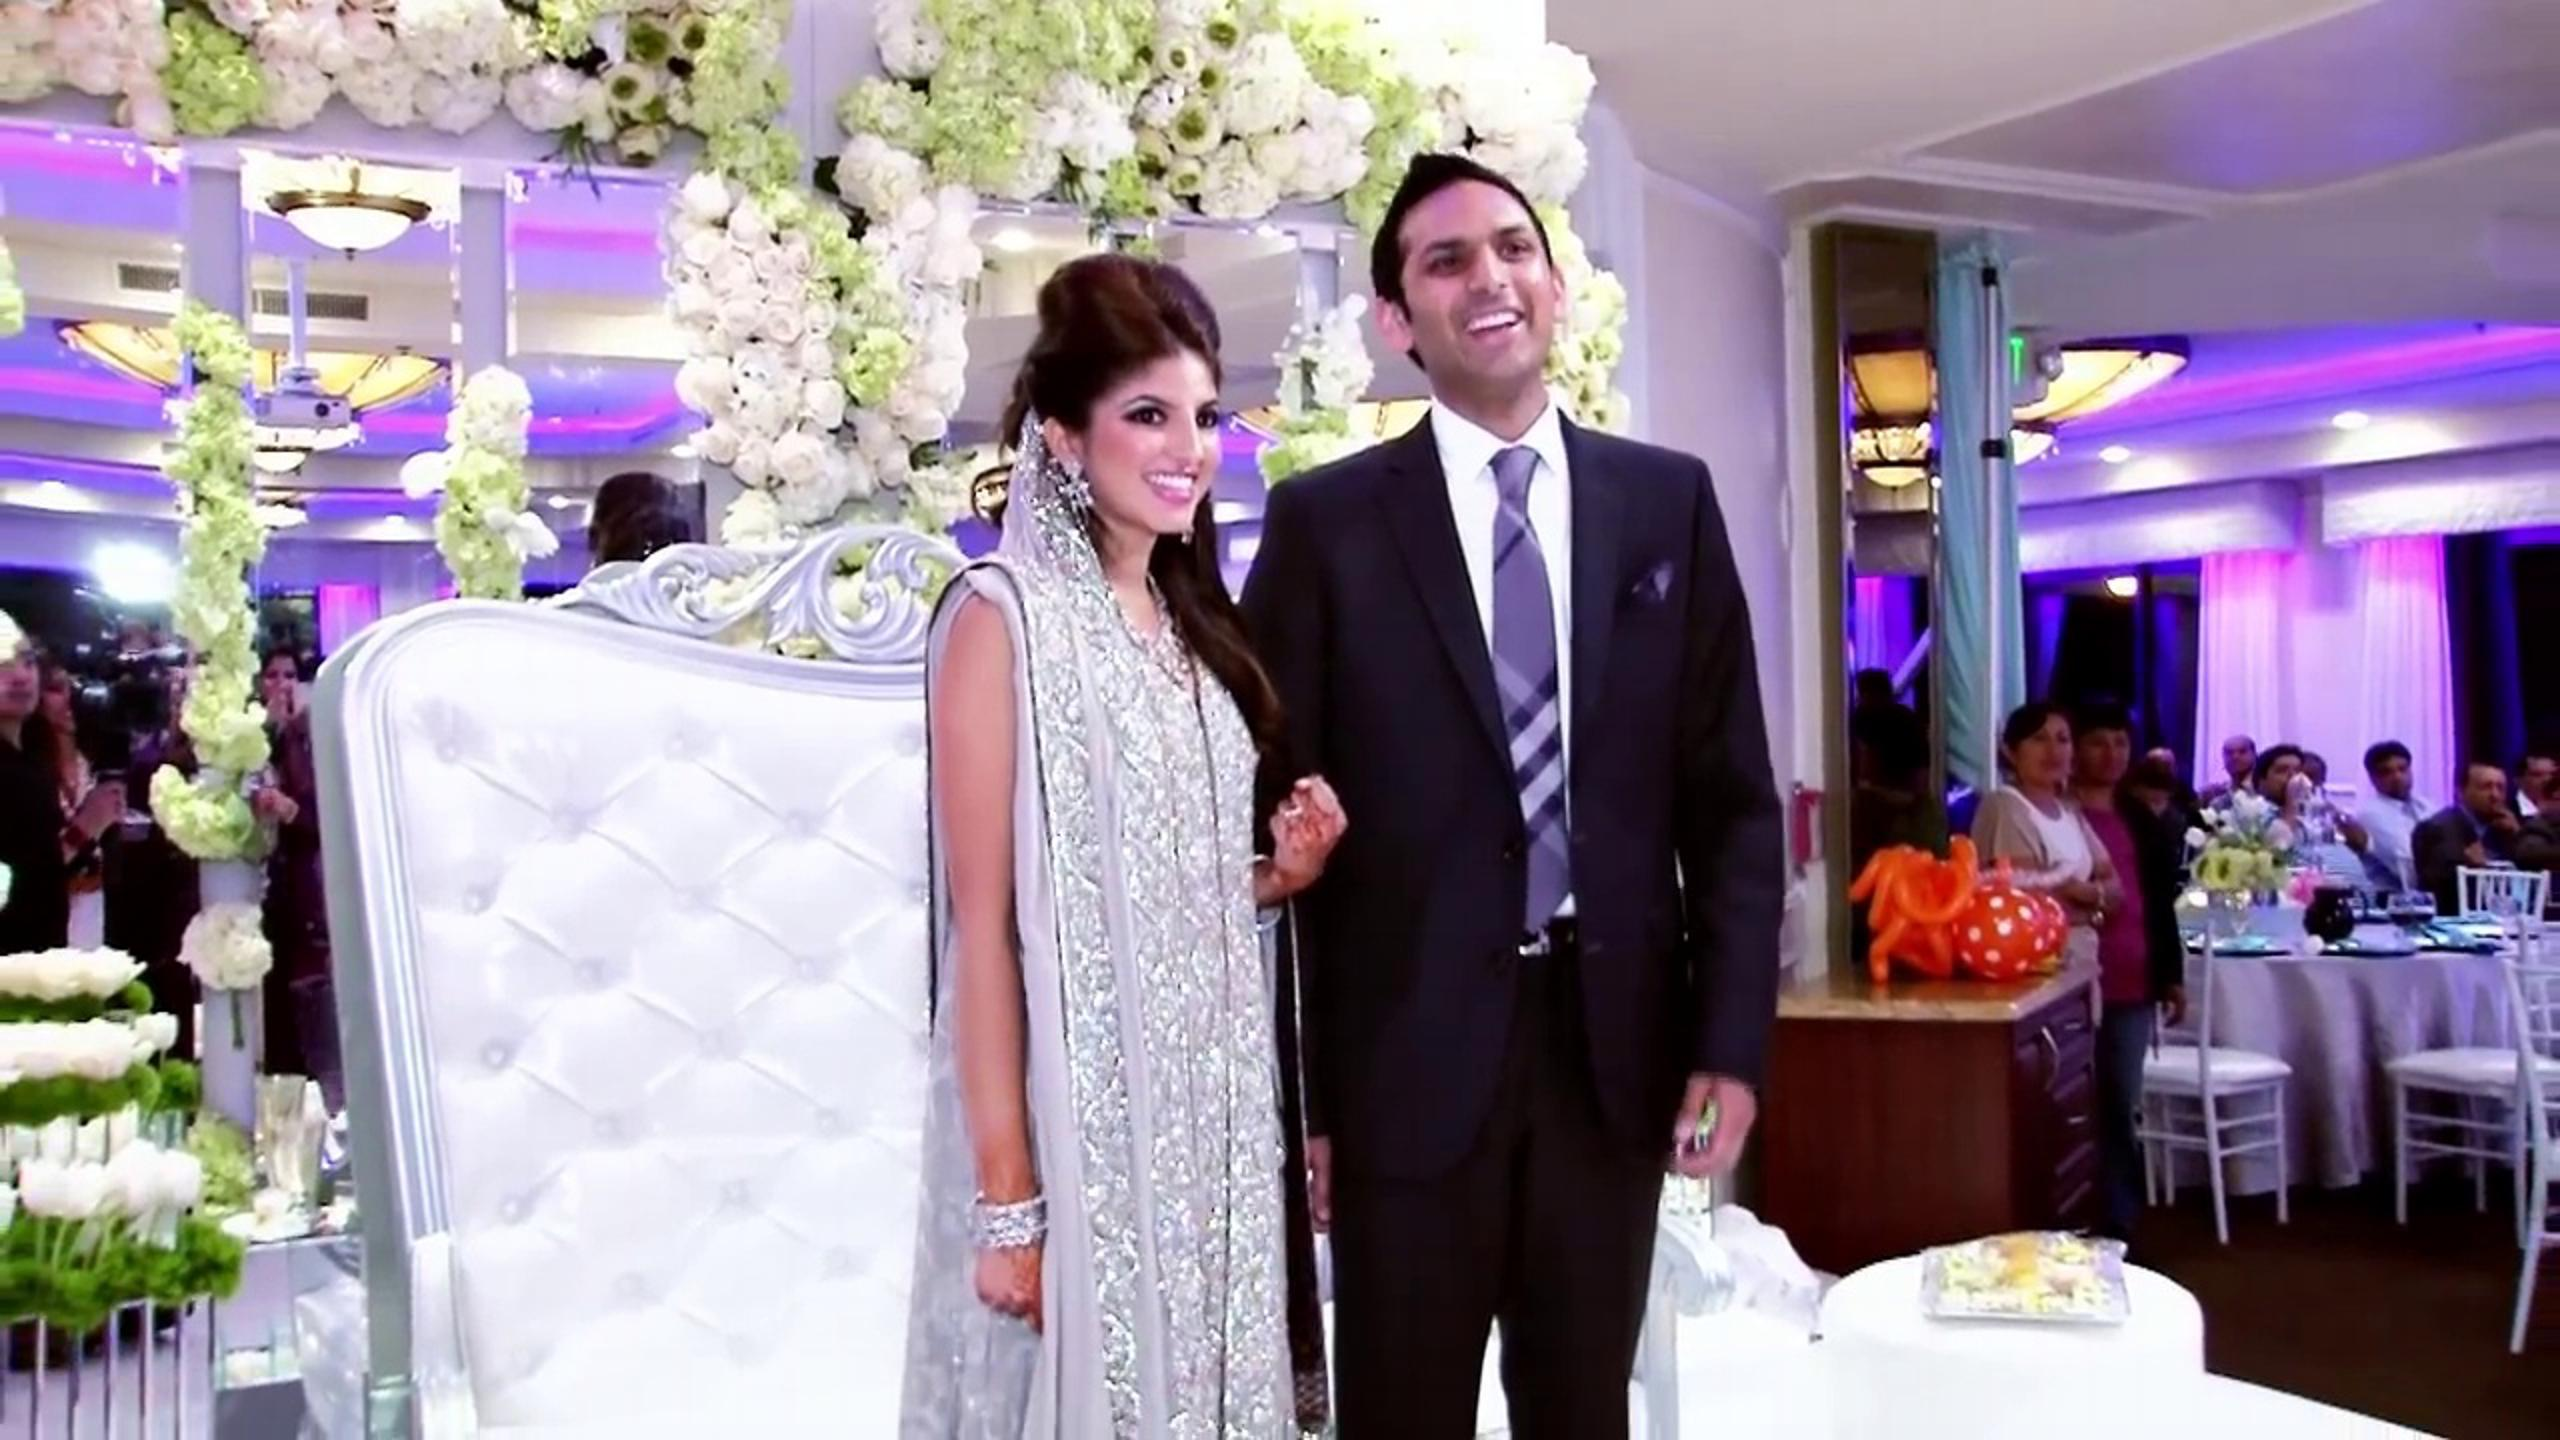

In [71]:
showimage('test4.jpg')

In [72]:
t = time.time()
evaluate('nanjol.png', model, 'nanjolno.png', output_dims=64, pre_upscale = True, clear_up = True, residual_model = True)
elapsed = time.time() - t
print(elapsed)

yay


/home/dsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:139: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


90.90779566764832


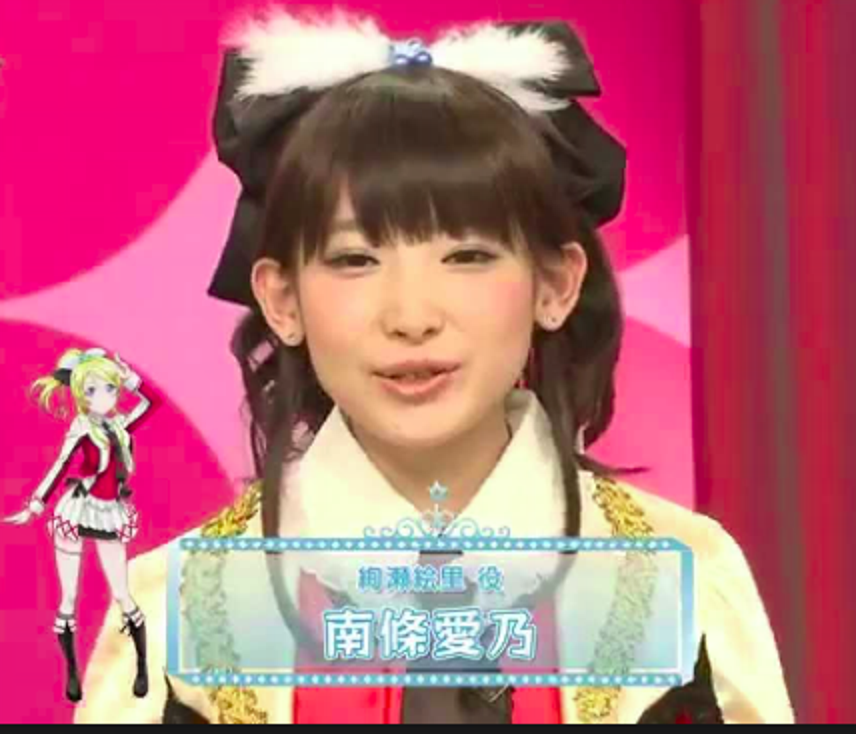

In [73]:
showimage('nanjolno.png')

In [74]:
t = time.time()
evaluate('nanjolno.png', model, 'nanjolno2.png', output_dims=64, pre_upscale = True, clear_up = True, residual_model = True)
elapsed = time.time() - t
print(elapsed)

yay


/home/dsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:139: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


353.0645704269409


In [75]:
showimage(url='nanjolno2.png')

In [76]:
t = time.time()
evaluate('7m.png', model, '7m1.png', output_dims=64, pre_upscale = True, clear_up = True, residual_model = True)
elapsed = time.time() - t
print(elapsed)

yay
45.964630126953125


/home/dsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:139: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [77]:
showimage(url='7m1.png')

In [78]:
t = time.time()
evaluate('7m1.png', model, '7m2.png', output_dims=64, pre_upscale = True, clear_up = True, residual_model = True)
elapsed = time.time() - t
print(elapsed)

yay


/home/dsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:139: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


175.19324159622192


In [79]:
showimage(url='7m2.png')

In [80]:
t = time.time()
evaluate('ferarri.png', model, 'ferarri1.png', output_dims=64, pre_upscale = True, clear_up = True, residual_model = True)
elapsed = time.time() - t
print(elapsed)

yay
32.38842725753784


/home/dsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:139: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [81]:
showimage(url='ferarri1.png')

In [82]:
t = time.time()
evaluate('nm7lr.png', model, 'nm7sr.png', output_dims=64, pre_upscale = True, clear_up = True, residual_model = True)
elapsed = time.time() - t
print(elapsed)

yay
32.3714873790741


/home/dsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:139: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [83]:
showimage(url='nm7sr.png')

In [84]:
t = time.time()
evaluate('nm7sr.png', model, 'nm7ssr.png', output_dims=64, pre_upscale = True, clear_up = True, residual_model = True)
elapsed = time.time() - t
print(elapsed)

yay


/home/dsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:139: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


122.87713623046875


In [85]:
showimage(url='nm7ssr.png')

In [86]:
t = time.time()
evaluate('nm7ssr.png', model, 'nm7ussr.png', output_dims=64, pre_upscale = True, clear_up = True, residual_model = True)
elapsed = time.time() - t
print(elapsed)

yay


/home/dsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:139: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


461.66356205940247


In [87]:
showimage(url='nm7ussr.png')

In [89]:
t = time.time()
evaluate('baliho.png', model, 'baliho1.png', output_dims=64, pre_upscale = True, clear_up = True, residual_model = True)
elapsed = time.time() - t
print(elapsed)

yay
50.436437129974365


/home/dsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:139: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [90]:
showimage(url='baliho1.png')

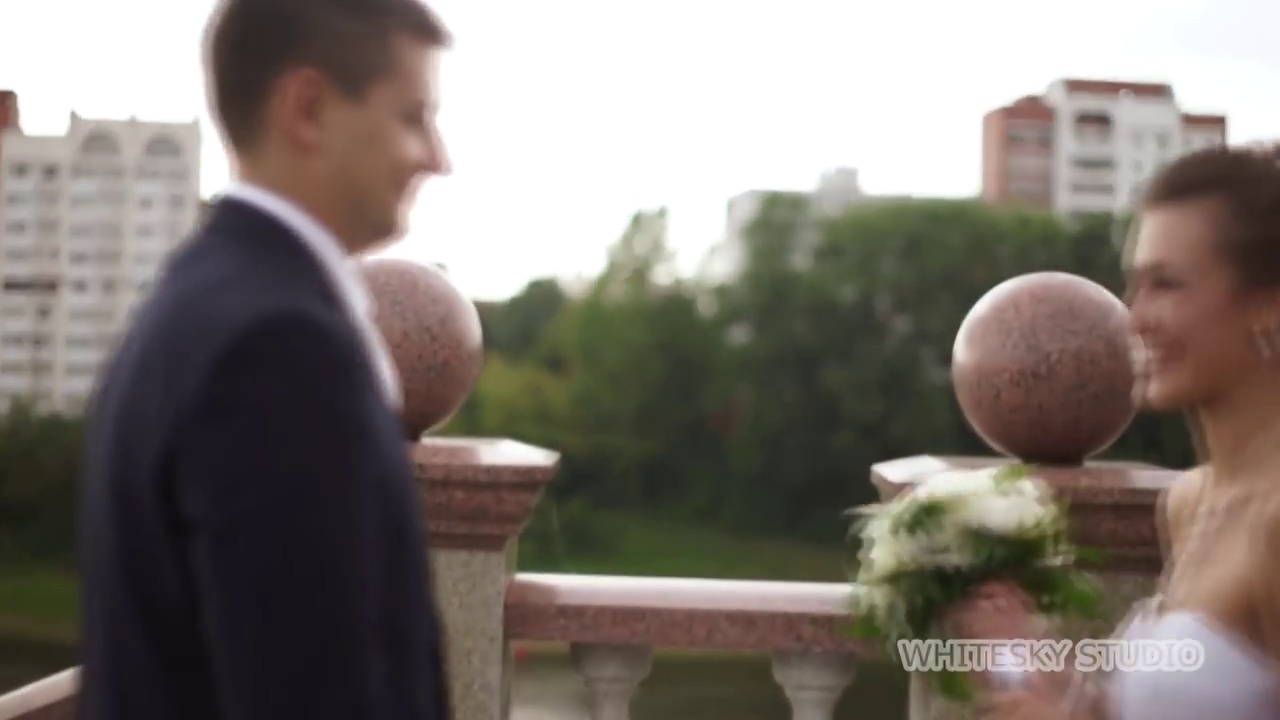

In [101]:
showimage('./720p/6_frame90.0_720p.jpg')

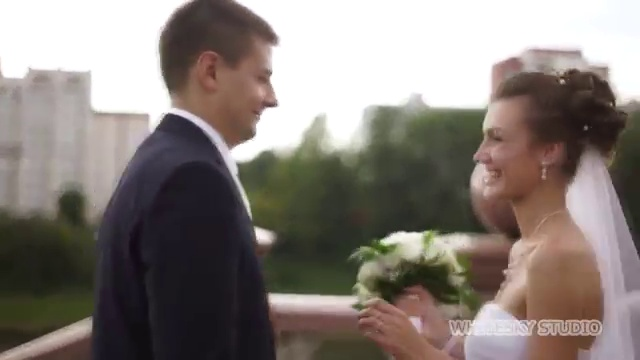

In [100]:
showimage('./360p/6_frame90.0_360p.jpg')